# Histograms for four regions: all time steps-Seasons
## ARMOR & ISAS - different criteria

This notebook is itended to show the general shape of the distribution of the Mixed Layer Depth in the different regions (described in [Regions](./Distribution-regions.ipynb)) using the ARMOR-3D and ISAS datasets. In the case of ISAS it is consiered different MLD estimation criteria. The years used here are 2006-2015. As an example, only the plots of the North East Atlantic region. 


This notebook has the following structure:

   [1. Imported modules](#1.-Imported-modules)
   [2. Dictionaries used](#2.-Dictionaries-used)
   [3. Functions](#3.-Functions)
   [4. Example plot](#4.-Example-plot)
    
In the following subsections will be described the code used and the size of the regions used.

## 1. Imported modules

In [1]:
#!/bin/python3

#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

## This module disable the print of warnings in the notebook
import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries used

This dictionary contains the points corresponding to the perimeter of the regions to use. It consists in a dictionary named 'reg_ext' whose key words are the short versions of the name of the regions. The value for each key is other dictionary, that contains the information of the longitude and latitude as tuples and the name in string for the region. 

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

## 3. Functions

In this notebook 7 different functions were used. Their names are: *Crops*, *Histogram*, *No_nan*, *Select*, *Season* and *Lists*. The description of each one is in the function's description.

In [3]:
## Function to crop the dataset
def Crops(coord, data_set, dic):
    """Crops is a function that takes a data set and crops it into a 
    smaller region, using as parameters the values given by the dictionary. 
        
    Parameters:
    ------------
    coord : string
        Key value that identifies the region to obtain.

    data_set : DataArray
        Dataset to be cropped.

    dic : dictionary
        Dictionary with the boundaries of the regions.

    Output:
    -------
    new_ds : DataArray
        New data array corresponding to the region stated by 'coord'.
    """
    
    lon1, lon2 = dic[coord]['lon']
    lat1, lat2 = dic[coord]['lat']
    name_fig = dic[coord]['name']
    
    new_ds = data_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we adre working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    
    ax.hist(a2, n_bins, range=ran, histtype=htype, label=label, alpha=alpha, 
            normed=normed, linewidth=lw)
        
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)



def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [4]:
def Select(month, i_date, f_date):
    return (month >= i_date) & (month <= f_date)


def Season(dataset, i_month, f_month):
    s = dataset.sel(time=Select(dataset['time.month'], i_month, f_month))
    return(s)


def Lists(dataset):
    l = []
    for j in range(len(dataset[:])):
        l = np.append(l, dataset[j])
        
    l2 = No_nan(l)
    return(l2)

## 4. Example plot

### North East Athantic

This region spans in longitude (30W, 5W), latitude (45N, 60N). This means, is a region of 25x15 degrees. This region, is thus, represented by: 

In [5]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '../../../New_ARMOR/'
dir_i= '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'ISAS15_DM_2002_2015_MLDS_0.03.nc'
fl_n2 = 'ISAS15_DM_2002_2015_MLDS_0.015.nc'
fl_n3 = 'ISAS15_DM_2002_2015_MLDS_0.046.nc'

fl_na = 'NARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_na, concat_dim='time')

c_isas1 = xr.open_dataset(dir_i + fl_n1, autoclose=True)   ## 030
c_isas2 = xr.open_dataset(dir_i + fl_n2, autoclose=True)   ## 015
c_isas3 = xr.open_dataset(dir_i + fl_n3, autoclose=True)   ## 046

In [6]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor.coords['time'] = (('time'), weeks)

In [7]:
labels = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = ['blue', 'green', 'red', 'orange']

In [8]:
## List of datasets
data_sets = [c_armor.mlotst, c_isas1.MLDP[:,0], c_isas2.MLDP[:,0], c_isas3.MLDP[:,0]]

## List of the identification of each dataset
ds_names = ['ARMOR 3D', 'ISAS-0.030', 'ISAS-0.015', 'ISAS-0.046']

## Name prefix for the figures, identifies the subregion plotted;
r = ['Gul', 'Lab', 'Irm', 'Noe', 'Nor1', 'Nor2']

## name suffix for the figures, identifies the dataset used.
name_sv = ['A', 'ISAS-030', 'ISAS-015', 'ISAS-046']

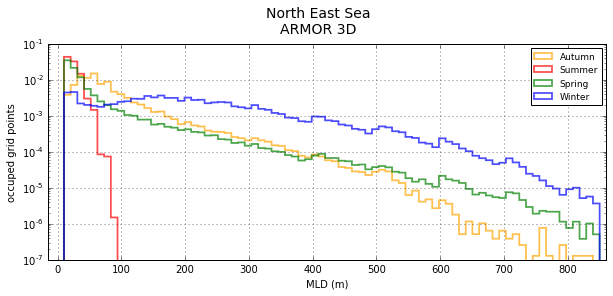

Noe-PDF-4SN-A.png


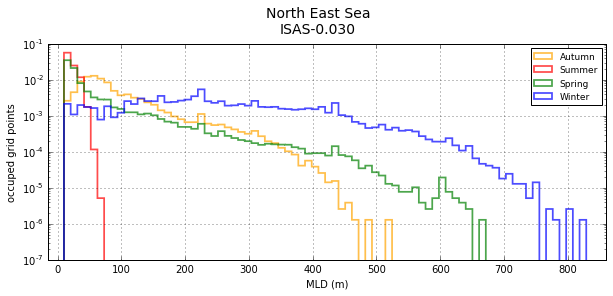

Noe-PDF-4SN-ISAS-030.png


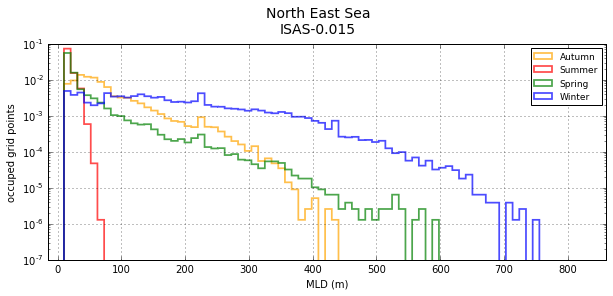

Noe-PDF-4SN-ISAS-015.png


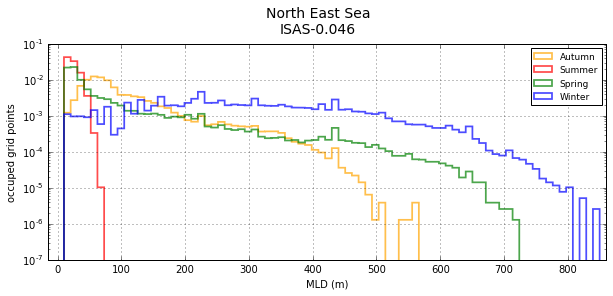

Noe-PDF-4SN-ISAS-046.png


In [9]:
###### Preparing the plot for the North East Region
## This histogram is for all data contained in the 
## in the complete region of Northe East in mld_a and mld_i. 
## For this region isas contains around 120*50*51 = 3.06e5 grid points

## Name of the subregion for the dictionary and 
## prefix to be used for the name.
coord = 'noe'
reg = r[3]


for d,dset in enumerate(data_sets):
    ## Chopping the dataset in the region
    data = Crops(coord, dset, reg_ext)
    data = data.sel(time=slice('2006-01-01', '2015-12-31'))

    ## Limits for the plot and number of bins
    xlims_n = 10, 850
    ylims_n = 1e-7, 1e-1
    n_bins_n = 80

    
    ## Masking for each of the months
    mask = data.time.dt.month 
    data.coords['month'] = (('time'), mask)
    
    
    ## Separating the data in Seasons
    winter_n = Season(data, 1, 3)
    spring_n = Season(data, 4, 6)
    summer_n = Season(data, 7, 9)
    autumn_n = Season(data, 10, 12)

    
    ran_n1 = (xlims_n) 

    
    ## Re-aranging of the dataset in lists
    a12_n1 = Lists(winter_n)
    a22_n1 = Lists(spring_n)
    a32_n1 = Lists(summer_n)
    a42_n1 = Lists(autumn_n)

    data1 = [a12_n1, a22_n1, a32_n1, a42_n1]


    ## Strings for title and save name of figure
    title_fig = reg_ext[coord]['name'] + '\n' + ds_names[d]
    save_name = reg + '-PDF-4SN-' + name_sv[d] + '.png'
    
    
    ## No stacked: Normalized, no cumulative plot
    ## To mak e acummulative plot do:  cumulative=True
    #%matplotlib notebook

    plt.close()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
    
    ## Making the histogram
    ax.hist(data1, n_bins_n, range=ran_n1, histtype='step', 
            align='mid', stacked=False, normed=True, cumulative=False,
            color=colors, label=labels, alpha=0.7, linewidth=1.75)

   
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                            top=0.85, wspace=0.25, hspace=0.5)

    
    ax.set_yscale("log", nonposy='clip')
    
    ax.set_xlim(-15., xlims_n[1]+10)
    ax.set_ylim(ylims_n)
   
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('occuped grid points', fontsize=10)
    
    ax.grid(True)
    plt.legend(fontsize=9)
    fig.suptitle(title_fig, fontsize=14)

    #plt.hlines(4396806, xlims_g[0], xlims_g[1])
    #plt.savefig(dir_o + save_name, bbox_inches='tight')

    plt.show()
    print(save_name)